# SVM

### Data Preparation

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [ ]:
df= pd.read_csv("final_prepared_data.csv")

In [ ]:
df['Volume'] = np.log1p(df['Volume'])
df['Volume_tomorrow'] = np.log1p(df['Volume_tomorrow'])

In [ ]:

df = df.head(10000)

drop_cols = ['level_0', 'index', 'Date']
target_cols = ['Volume_tomorrow', 'Open_tomorrow', 'High_tomorrow',
               'Low_tomorrow', 'Close_tomorrow', 'Adj close_tomorrow']

# Separate features and targets
X_raw = df.drop(columns=drop_cols + target_cols)
y = df[target_cols]

# Identify feature types BEFORE transformation
numeric_features = X_raw.select_dtypes(exclude=['object']).columns.tolist()
categorical_features = X_raw.select_dtypes(include=['object']).columns.tolist()

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan), categorical_features)
    ]
)

# Fit and transform
X_transformed = preprocessor.fit_transform(X_raw)

# Combine numeric + categorical column names
all_feature_names = numeric_features + categorical_features

# Reconstruct DataFrame with feature names
X = pd.DataFrame(X_transformed, columns=all_feature_names)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=True
)


In [ ]:
X

,Volume,Open,High,Low,Close,Adj close,Sentiment_gpt,News_flag,Scaled_sentiment,high_to_low,close_to_open,daily_range_pct,volume_per_price,Symbol
0,-0.120050,0.358681,0.346090,0.361817,0.352179,0.443334,0.063747,2.173499,0.063747,-0.862496,-0.356198,-0.887715,-0.404390,13.0
1,-0.153773,0.353471,0.347951,0.364601,0.354060,0.445169,0.063747,-0.460088,0.063747,-0.913254,0.035597,-0.936754,-0.405808,13.0
2,0.699978,0.352892,0.340938,0.341893,0.329610,0.421318,0.063747,-0.460088,0.063747,-0.014584,-1.288838,-0.021528,-0.341350,13.0
3,0.745628,0.329298,0.325480,0.330760,0.321074,0.412991,0.063747,-0.460088,0.063747,-0.271811,-0.462111,-0.273941,-0.334802,13.0
4,0.314150,0.333351,0.339363,0.346581,0.346103,0.437407,0.063747,-0.460088,0.063747,-0.379029,0.721485,-0.374536,-0.379755,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.976499,-0.736599,-0.736306,-0.737071,-0.735990,-0.656317,0.063747,2.173499,0.063747,-0.572623,0.232046,-0.583950,0.525565,6.0
9996,1.651457,-0.737980,-0.736419,-0.737772,-0.736376,-0.655238,-0.395269,-0.460088,-0.395269,-0.329509,0.635352,-0.325416,1.901741,25.0
9997,-0.249524,0.086417,0.090466,0.093871,0.093791,-0.107279,0.710673,-0.460088,0.710673,-0.244565,0.520573,-0.237048,-0.402473,19.0
9998,-0.060916,-0.398875,-0.399922,-0.400526,-0.398899,-0.289348,-1.385913,-0.460088,-1.385913,-0.092697,-0.003852,-0.091611,-0.351650,10.0


### Model

In [ ]:
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Initialize base SVM model
base_svm = SVR(kernel='rbf', C=10, gamma=0.1, epsilon=0.1)

# Wrap in MultiOutputRegressor
multi_svm = MultiOutputRegressor(base_svm)

# Train on multi-targets
multi_svm.fit(X_train, y_train)

# Predict on test set
svm_predictions = multi_svm.predict(X_test)



In [ ]:
for i, col in enumerate(y_test.columns):
    rmse = np.sqrt(mean_squared_error(y_test[col], svm_predictions[:, i]))
    mse = mean_squared_error(y_test.iloc[:, i], svm_predictions[:, i])
    r2 = r2_score(y_test.iloc[:, i], svm_predictions[:, i])
    print(f"{col} - MSE: {mse:.4f}, R2: {r2:.4f}")
    print(f"SVM RMSE for {col}: {rmse:.4f}")


Volume_tomorrow - MSE: 0.1554, R2: 0.9123
SVM RMSE for Volume_tomorrow: 0.3942
Open_tomorrow - MSE: 101.7596, R2: 0.9787
SVM RMSE for Open_tomorrow: 10.0876
High_tomorrow - MSE: 111.5016, R2: 0.9772
SVM RMSE for High_tomorrow: 10.5594
Low_tomorrow - MSE: 99.9986, R2: 0.9786
SVM RMSE for Low_tomorrow: 9.9999
Close_tomorrow - MSE: 107.2596, R2: 0.9776
SVM RMSE for Close_tomorrow: 10.3566
Adj close_tomorrow - MSE: 114.0859, R2: 0.9774
SVM RMSE for Adj close_tomorrow: 10.6811


In [ ]:
y_pred = svm_predictions

#EDA

###  Visualize predictions vs actual values


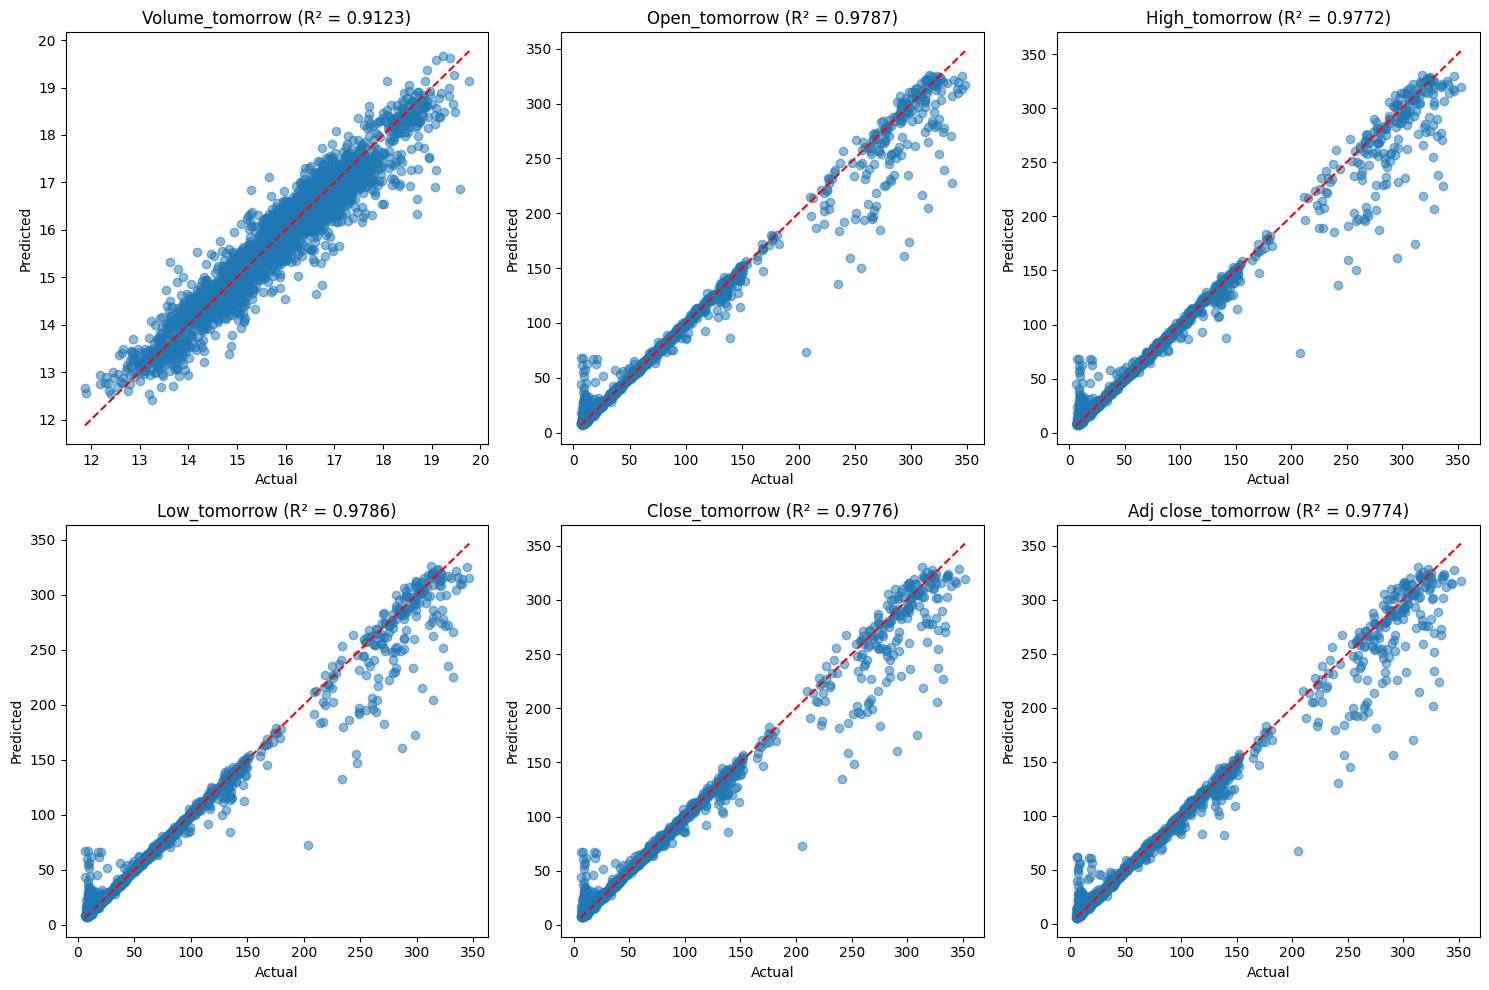

In [ ]:
import matplotlib.pyplot as plt
# Visualize predictions vs actual values
plt.figure(figsize=(15, 10))
for i, col in enumerate(y_test.columns):
    plt.subplot(2, 3, i+1)
    plt.scatter(y_test.iloc[:, i], y_pred[:, i], alpha=0.5)
    plt.plot([y_test.iloc[:, i].min(), y_test.iloc[:, i].max()],
             [y_test.iloc[:, i].min(), y_test.iloc[:, i].max()], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{col} (R² = {r2_score(y_test.iloc[:, i], y_pred[:, i]):.4f})')
plt.tight_layout()
plt.savefig('prediction_results.png')
plt.show()

### Feature Importance

In [ ]:
!pip install eli5


In [ ]:

import eli5
from eli5.sklearn import PermutationImportance

In [ ]:


perm = PermutationImportance(multi_svm.estimators_[0], random_state=42).fit(X_test, y_test.iloc[:, 0])

eli5.show_weights(perm, feature_names=X_test.columns.tolist())

Weight,Feature
0.5535 ± 0.0274,Volume
0.3622 ± 0.0084,Symbol
0.2001 ± 0.0090,Adj close
0.1058 ± 0.0049,Open
0.1038 ± 0.0053,Close
0.0950 ± 0.0028,Low
0.0942 ± 0.0065,High
0.0876 ± 0.0069,volume_per_price
0.0220 ± 0.0050,daily_range_pct
0.0191 ± 0.0015,Scaled_sentiment


In [ ]:
eli5.show_weights(perm, feature_names=X_test.columns.tolist())

Weight,Feature
0.5535 ± 0.0274,Volume
0.3622 ± 0.0084,Symbol
0.2001 ± 0.0090,Adj close
0.1058 ± 0.0049,Open
0.1038 ± 0.0053,Close
0.0950 ± 0.0028,Low
0.0942 ± 0.0065,High
0.0876 ± 0.0069,volume_per_price
0.0220 ± 0.0050,daily_range_pct
0.0191 ± 0.0015,Scaled_sentiment


### Lime

In [ ]:
!pip install lime


In [ ]:


import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=y_train.columns.tolist(),
    mode='regression'
)

instance_idx = 0
instance = X_test.iloc[instance_idx]


# Explain the instance
exp = explainer.explain_instance(
    data_row=instance.values,
    predict_fn=multi_svm.predict,
    num_features=10 # Number of top features to display
)





In [ ]:
# Show the explanation
exp.show_in_notebook(show_table=True)





In [ ]:
explanation_data = exp.as_list()
print(explanation_data)


[('Volume > 0.64', 0.5897691965773406), ('volume_per_price > -0.10', 0.2636495110964357), ('Open <= -0.64', 0.12257217510415014), ('Adj close <= -0.56', -0.10972987851931948), ('Low <= -0.64', 0.09810151813195915), ('High <= -0.63', 0.09449419183785938), ('Close <= -0.64', 0.07201890681255259), ('high_to_low > 0.31', 0.05360410635549858), ('close_to_open > 0.50', 0.05096422138277447), ('News_flag <= -0.46', -0.03209964858137953)]


### SHAP

In [ ]:
!pip install shap


In [ ]:
X_test_sample = pd.DataFrame(X_test.values, columns=X_train.columns)



In [ ]:

import shap


X_test_sample = X_test.sample(n=3, random_state=42)

def predict_fn(X):
    return multi_svm.predict(X)

explainer = shap.KernelExplainer(multi_svm.predict, 3)
shap_values = explainer(X_test_sample)

shap.summary_plot(shap_values, X_test_sample, feature_names=X.columns, show=True)


In [ ]:
for i, target_name in enumerate(y.columns):
    print(f"\nSummary plot for target: {target_name}")
    explainer = shap.Explainer(multi_xgb.estimators_[i], X_train)
    shap_values = explainer(X_test_sample)

    shap.summary_plot(shap_values, X_test_sample, feature_names=X.columns, show=True)


In [ ]:
# Explain one sample for the first target
explainer = shap.Explainer(multi_xgb.estimators_[0], X_train)
shap_values = explainer(X_test_sample)

# Waterfall for the first sample
shap.plots.waterfall(shap_values[0])


### PDP

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

feature_index = 5
target_index = 0

# PDP works on estimator fitted on a single output
estimator = multi_svm.estimators_[target_index]

# Apply PDP (if X has named columns, you can use feature name instead of index)
disp = PartialDependenceDisplay.from_estimator(
    estimator,
    X,
    features=[feature_index],
    kind="average",
    n_jobs=-1,
    grid_resolution=100
)

plt.title(f'Partial Dependence Plot for target: {y.columns[target_index]}')
plt.show()


this means around flatten, because the range is very very smmall. which means the Adj close didn't have a strong relation with Volume Tomorrow

In [ ]:
for i, target_name in enumerate(y.columns):
    estimator = multi_xgb.estimators_[i]
    PartialDependenceDisplay.from_estimator(
        estimator, X, features=[feature_index], kind="average"
    )
    plt.title(f"PDP for feature {feature_index} → target: {target_name}")
    plt.show()


### ICE

In [ ]:


feature_index = 5
target_index = 0

In [ ]:
for i, target_name in enumerate(y.columns):
    fig, ax = plt.subplots(figsize=(12, 6))
    PartialDependenceDisplay.from_estimator(
        multi_xgb.estimators_[i],
        X,
        features=[feature_index],
        kind='both',
        grid_resolution=100,
        ax=ax
    )
    plt.title(f'ICE Plot for target: {target_name}')
    plt.show()
